Part A

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Epoch 1/100
32/32 [==============================] - 10s 70ms/step - loss: 34815.0195 - val_loss: 20193.8086
Epoch 2/100
32/32 [==============================] - 1s 29ms/step - loss: 16881.0723 - val_loss: 7849.9272
Epoch 3/100
32/32 [==============================] - 1s 31ms/step - loss: 11633.8105 - val_loss: 4272.6914
Epoch 4/100
32/32 [==============================] - 1s 23ms/step - loss: 10479.8535 - val_loss: 3875.8779
Epoch 5/100
32/32 [==============================] - 1s 24ms/step - loss: 10663.4229 - val_loss: 5506.2104
Epoch 6/100
32/32 [==============================] - 1s 26ms/step - loss: 11723.9004 - val_loss: 3752.5100
Epoch 7/100
32/32 [==============================] - 1s 26ms/step - loss: 10156.8027 - val_loss: 4688.7002
Epoch 8/100
32/32 [==============================] - 1s 26ms/step - loss: 10853.1895 - val_loss: 14147.7666
Epoch 9/100
32/32 [==============================] - 1s 24ms/step - loss: 11927.9688 - val_loss: 4065.4490
Epoch 10/100
32/32 [==============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 177ms/step


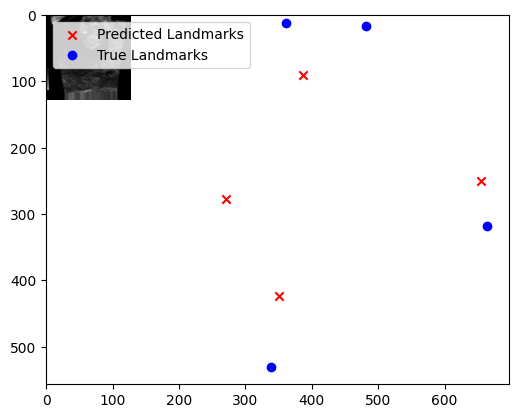

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Task - Landmark-20240126T134839Z-001/Task - Landmark/role_challenge_dataset_ground_truth.csv')

# Define functions for data preprocessing
def preprocess_data(image_path, landmarks):
    image = load_and_preprocess_image(image_path)
    landmarks = landmarks.to_numpy(dtype='float32')
    return image, landmarks

def load_and_preprocess_image(image_path):
    image_height, image_width = 128, 128
    image_path = f'/content/drive/MyDrive/Task - Landmark-20240126T134839Z-001/Task - Landmark/images/{image_path}'
    image = cv2.imread(image_path)
    image = cv2.resize(image, (image_width, image_height))

    # Apply data augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )
    image = datagen.random_transform(image)

    image = image / 255.0
    return image

# Define the model architecture
def create_landmark_detection_model():
    model = keras.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(512, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.15),
        layers.Dense(256, activation='relu'),
        layers.Dense(8)  # Output layer with 8 nodes for landmark coordinates
    ])
    return model

# Split the data into train, validation, and test sets
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
train_df, val_df, test_df = df[:train_size], df[train_size:train_size + val_size], df[train_size + val_size:]

# Preprocess the data
train_data = [preprocess_data(row['image_name'], row[['ofd_1_x', 'ofd_1_y', 'ofd_2_x', 'ofd_2_y', 'bpd_1_x', 'bpd_1_y', 'bpd_2_x', 'bpd_2_y']]) for _, row in train_df.iterrows()]
val_data = [preprocess_data(row['image_name'], row[['ofd_1_x', 'ofd_1_y', 'ofd_2_x', 'ofd_2_y', 'bpd_1_x', 'bpd_1_y', 'bpd_2_x', 'bpd_2_y']]) for _, row in val_df.iterrows()]

# Create and compile the model
model = create_landmark_detection_model()
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(
    np.array([data[0] for data in train_data]),
    np.array([data[1] for data in train_data]),
    epochs=100,
    batch_size=16,
    validation_data=(
        np.array([data[0] for data in val_data]),
        np.array([data[1] for data in val_data])
    )
)

# Evaluate the model on the test set
test_data = [preprocess_data(row['image_name'], row[['ofd_1_x', 'ofd_1_y', 'ofd_2_x', 'ofd_2_y', 'bpd_1_x', 'bpd_1_y', 'bpd_2_x', 'bpd_2_y']]) for _, row in test_df.iterrows()]
loss = model.evaluate(
    np.array([data[0] for data in test_data]),
    np.array([data[1] for data in test_data])
)

print(f'Test Loss: {loss}')
model.save('part_A_model.h5')
model.save_weights('Part_A_model_weights_hypothesis.h5')
# Visualize predictions on sample images
sample_row = df.iloc[0]  # Choose a sample row for visualization
sample_image = preprocess_data(sample_row['image_name'], sample_row[['ofd_1_x', 'ofd_1_y', 'ofd_2_x', 'ofd_2_y', 'bpd_1_x', 'bpd_1_y', 'bpd_2_x', 'bpd_2_y']])
prediction = model.predict(np.array([sample_image[0]]))[0]

plt.imshow(sample_image[0])
plt.scatter(prediction[0::2], prediction[1::2], c='red', marker='x', label='Predicted Landmarks')
plt.scatter(sample_image[1][0::2], sample_image[1][1::2], c='blue', marker='o', label='True Landmarks')
plt.legend()
plt.show()
